In [891]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import sys
import math

%matplotlib inline

In [892]:
# import data
df = pd.read_csv('fashionphile-20181219.csv')
df.head(n = 3)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,brand,url,price,retail,original,buyback,bag,like,sold,condition,listed_date,sold_date
0,10001,Fashionphile eGift Card,Fashionphile SWAG,https://www.fashionphile.com/fashionphile-egif...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,2018-11-22,NaN
1,10002,FASHIONPHILE Handbag Calendar,Fashionphile SWAG,https://www.fashionphile.com/fashionphile-hand...,NaN,NaN,NaN,NaN,NaN,NaN,True,New,2018-11-22,2018-11-22
2,10004,FASHIONPHILE Pet Picks Calendar,Fashionphile SWAG,https://www.fashionphile.com/fashionphile-pet-...,NaN,NaN,NaN,NaN,NaN,NaN,True,New,2018-11-22,2018-11-22


In [893]:
df['brand'].unique()

array(['Fashionphile SWAG', 'Bottega Veneta', 'Gucci', 'Marc Jacobs',
       'Prada', 'Louis Vuitton', 'Balenciaga', 'Jimmy Choo', 'Fendi',
       'Chanel', 'Yves Saint Laurent', nan, 'Miu Miu', 'Hermes', 'Goyard',
       'Burberry', 'Chloe', 'Valentino', 'Christian Dior',
       'Nancy Gonzalez', 'Lanvin', 'Christian Louboutin', 'Judith Leiber',
       'Alexander Wang', 'Givenchy', 'Celine', 'Chopard', 'David Yurman',
       'Tiffany', 'Cartier', 'Van Cleef & Arpels', 'Mikimoto',
       'Alexander McQueen', 'Tom Ford', 'Proenza Schouler',
       'Stella McCartney', 'Mulberry', 'Bulgari', 'Harry Winston',
       'Rolex', 'Phillip Lim', 'Versace', 'Dolce Gabbana', 'Judith Ripka',
       'Oliver Peoples', 'Patek Philippe', 'John Hardy', 'Loewe', 'MCM',
       'Delvaux', 'Panerai', 'Mansur Gavriel', 'Alaia', 'Omega',
       'Manolo Blahnik', 'IWC'], dtype=object)

In [894]:
# Drop irrelevant brands that are not bags, drop url column
df = df.drop(['url'], axis = 1)
not_bag = ['Fashionphile SWAG', 'Christian Louboutin', 'Chopard','David Yurman', 'Tiffany', 'Cartier',
          'Van Cleef & Arpels', 'Mikimoto', 'Tom Ford', 'Bulgari', 'Harry Winston', 'Rolex',
          'Judith Ripka', 'Oliver Peoples', 'Patek Philippe', 'John Hardy', 'Panerai', 'Omega',
          'Manolo Blahnik', 'IWC']
for name in not_bag:
    df = df[df['brand'] != name].copy()

In [895]:
# summary of data
print('Total number of items:', df.shape[0])
print('Items with price information:', df[df['price'].notnull()].shape[0])
print('Items sold between 2018-11-30 and 2018-12-19:', df[df['sold']==True 
                                                         & (df['sold_date']!='2018-11-22')
                                                         & (df['sold_date']!='2018-11-21')
                                                         & (df['sold_date']!='2018-11-27')].shape[0])
print('Items not yet sold:', df[df['sold'].isnull()].shape[0])

Total number of items: 252616
Items with price information: 13254
Items sold between 2018-11-30 and 2018-12-19: 4750
Items not yet sold: 6223


In [896]:
sales_dates = df[df['sold']==True 
     & (df['sold_date']!='2018-11-22') & (df['sold_date']!='2018-11-21') 
                 & (df['sold_date']!='2018-11-27')]['sold_date'].unique()
print('Dates on which there are items sold (sales_dates):', sales_dates)

Dates on which there are items sold (sales_dates): ['2018-12-01' '2018-12-09' '2018-12-17' '2018-12-11' '2018-11-30'
 '2018-12-03' '2018-12-20' '2018-12-13' '2018-12-07' '2018-12-05']


Sale volume every two/three days:
             volume
2018-12-01     297
2018-12-09     457
2018-12-17     721
2018-12-11     319
2018-11-30     611
2018-12-03     452
2018-12-20     862
2018-12-13     327
2018-12-07     369
2018-12-05     335


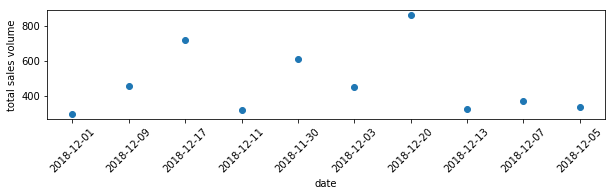

In [897]:
# sales volume by day
sales_volume = {} #create an empty dict to store sales volume every two days
for i in sales_dates:
    sales_volume[i] = df[df['sold']==True & (df['sold_date']==i)].shape[0]
sales_volume_df = df.from_dict(sales_volume, orient='index', columns=['volume'])

print('Sale volume every two/three days:\n', sales_volume_df) 
plt.figure(figsize=(10,2))
plt.plot(sales_volume_df, 'o')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('total sales volume')
plt.show()

Sales revenue by date
               revenue
2018-12-01   365165.0
2018-12-09   568530.0
2018-12-17   805245.0
2018-12-11   351935.0
2018-11-30   654055.0
2018-12-03   504310.0
2018-12-20  1047350.0
2018-12-13   372015.0
2018-12-07   501775.0
2018-12-05   392775.0


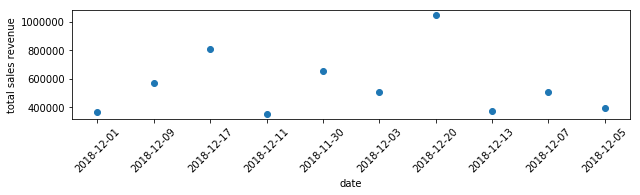

In [898]:
# total sales revenue by date
sales_revenue = {}
for i in sales_dates:
    sales_revenue[i] = df[df['sold']==True & (df['sold_date']==i)]['price'].sum(skipna = True).round()
sales_revenue_df = df.from_dict(sales_revenue, orient='index', columns=['revenue'])

print('Sales revenue by date\n', sales_revenue_df)
plt.figure(figsize=(10,2))
plt.plot(sales_revenue_df, 'o')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('total sales revenue')
plt.show()

In [899]:
print('Average sales volume per day:', sales_volume_df.values.sum()/20)
print('Average revenue per day:', sales_revenue_df.values.sum()/20)

Average sales volume per day: 237.5
Average revenue per day: 278157.75


In [900]:
df.head()

,id,name,brand,price,retail,original,buyback,bag,like,sold,condition,listed_date,sold_date
3,10073,BOTTEGA VENETA Leather Wing Tip Flats 35 Nero,Bottega Veneta,NaN,NaN,NaN,NaN,NaN,NaN,True,Good,2018-11-22,2018-11-22
4,10074,GUCCI Logo Sunglasses 130 1430/S Gray,Gucci,NaN,NaN,NaN,NaN,NaN,NaN,True,Good,2018-11-22,2018-11-22
5,10075,MARC JACOBS Denim Rocker Black,Marc Jacobs,NaN,NaN,NaN,NaN,NaN,NaN,True,Excellent,2018-11-22,2018-11-22
6,10076,PRADA Leather Antic Black,Prada,NaN,NaN,NaN,NaN,NaN,NaN,True,Good,2018-11-22,2018-11-22
7,10077,LOUIS VUITTON Epi Sarah Wallet Porte-Monnaie C...,Louis Vuitton,NaN,NaN,NaN,NaN,NaN,NaN,True,Good,2018-11-22,2018-11-22


# Brand Populatiry 
### Overall popularity by brand: Sold + Available

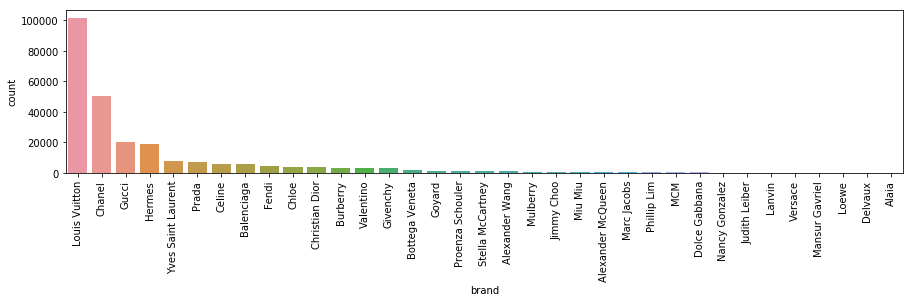

In [901]:
df_sold = df[df['sold']==True]
df_available = df[df['sold'].isnull()]

# Overall popularity sold+available
f, (ax1) = plt.subplots(1,1, figsize = (15, 3))
sns.countplot(x = df['brand'], data = df, ax = ax1, order = df['brand'].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

### Sold items

Total number of sold itmes: 246393


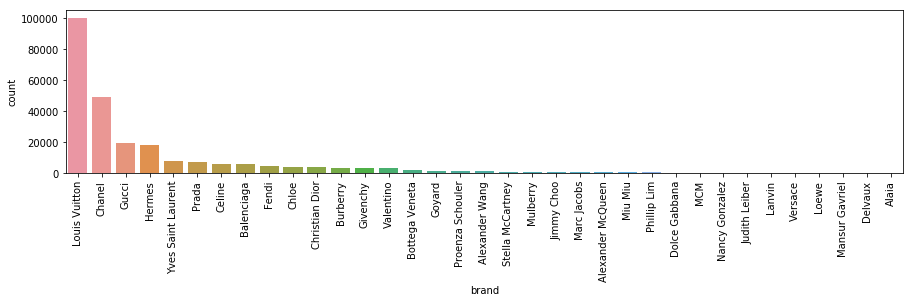

In [902]:
print('Total number of sold itmes:', df[df['sold']==True].shape[0])

f, (ax1) = plt.subplots(1,1, figsize = (15, 3))
sns.countplot(x = df_sold['brand'], data = df_sold, ax = ax1, order = df_sold['brand'].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

### Available items

Total number of available itmes: 6223


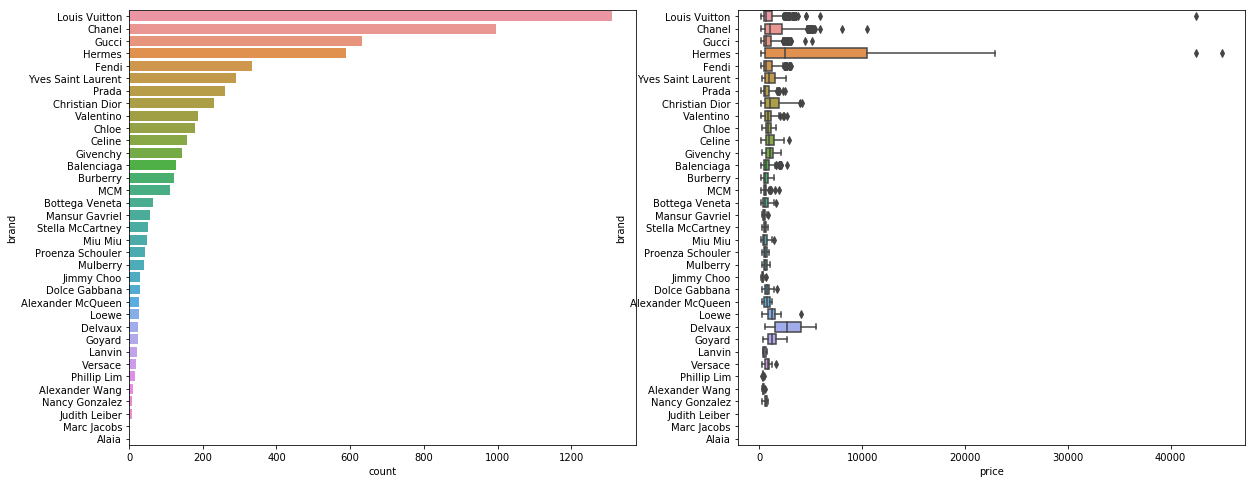

In [903]:
print('Total number of available itmes:', df[df['sold'].isnull()].shape[0])

f, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 8))
sns.countplot(y = df_available['brand'], data = df_available, ax = ax1, 
              order = df_available['brand'].value_counts().index)
sns.boxplot(y = df_available['brand'], x = df_available['price'], data = df_available, ax = ax2, 
            order = df_available['brand'].value_counts().index)
# plt.xticks(rotation = 90)
plt.show()

### Popularity by item

In [904]:
df['name'].describe()

count                               252616
unique                               98135
top       LOUIS VUITTON Monogram Speedy 30
freq                                   872
Name: name, dtype: object

In [905]:
print('Top ten most popular items:')
df['name'].value_counts()[:10]

Top ten most popular items:


LOUIS VUITTON Monogram Speedy 30                       872
LOUIS VUITTON Damier Ebene Speedy 30                   649
LOUIS VUITTON Monogram Speedy 25                       597
LOUIS VUITTON Monogram Pochette Metis                  548
LOUIS VUITTON Monogram Artsy MM                        528
LOUIS VUITTON Monogram Pochette Accessories            520
LOUIS VUITTON Damier Ebene Neverfull MM                513
CHANEL Caviar Quilted Grand Shopping Tote GST Black    460
LOUIS VUITTON Monogram Neverfull MM                    430
LOUIS VUITTON Damier Ebene Eva Clutch                  426
Name: name, dtype: int64

### Adding a popularity column to dataframe based on frequency of item

In [906]:
# adding a popularity column to dataframe
df['popularity'] = df.groupby('name')['name'].transform('count')

In [908]:
df.shape

(252616, 14)

# Pricing model
To predict sales price using brand, name, retail, bag, like, sold, condition, list_length

In [909]:
# entires with sale price information
df_price = df[df['price'].notnull()]
df_price.shape

(13254, 14)

In [910]:
# entires with both sale price and retail price information 
df_price_retail = df_price[df_price['retail'].notnull()].copy()
df_price_retail.shape

(8070, 14)

In [911]:
# top popular items
df_price_retail['name'].value_counts()[:10]

CHANEL Caviar Quilted Jumbo Double Flap Black          24
GUCCI Pebbled Calfskin Small Soho Disco Bag Black      21
LOUIS VUITTON Monogram Speedy 30                       20
LOUIS VUITTON Damier Ebene Neo Neverfull MM            19
LOUIS VUITTON Monogram Artsy MM                        17
LOUIS VUITTON Damier Azur Speedy 30                    16
CHANEL Caviar Quilted Grand Shopping Tote GST Black    16
LOUIS VUITTON Monogram Odeon PM                        15
LOUIS VUITTON Monogram Speedy 25                       14
LOUIS VUITTON Damier Ebene Speedy 30                   14
Name: name, dtype: int64

### Price distribution by brands 

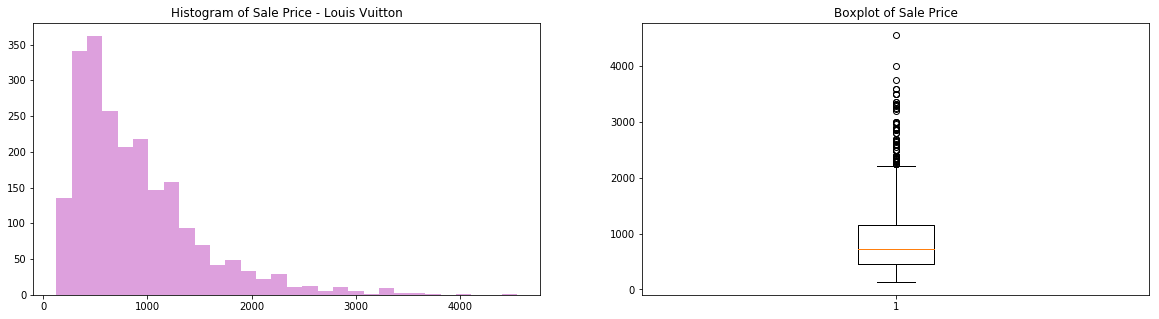

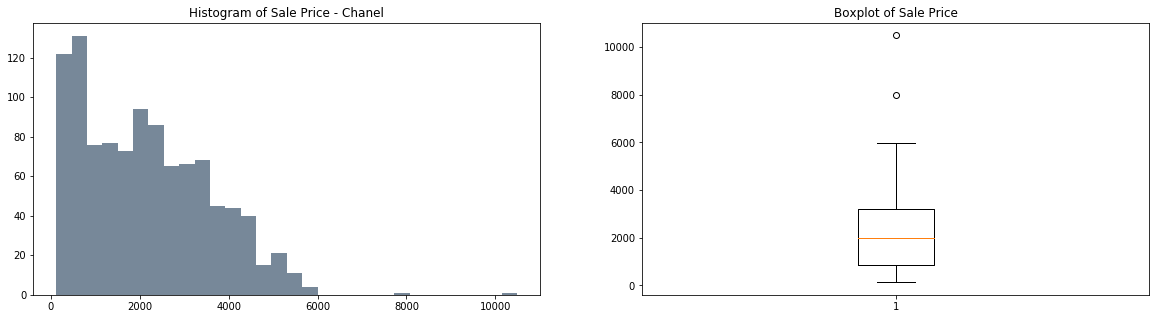

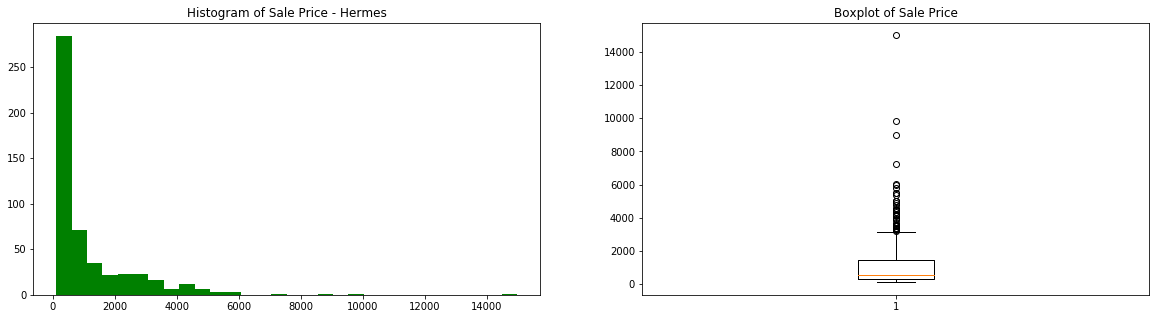

In [912]:
# Louis Vuitton
df_LV = df_price_retail[df_price_retail['brand'] == 'Louis Vuitton']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.hist(df_LV['price'], bins=30, color='plum')
ax2.boxplot(df_LV['price'])

ax1.set_title("Histogram of Sale Price - Louis Vuitton")
ax2.set_title("Boxplot of Sale Price")
plt.show()

# Chanel
df_chanel = df_price_retail[df_price_retail['brand'] == 'Chanel']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.hist(df_chanel['price'], bins=30, color='lightslategray')
ax2.boxplot(df_chanel['price'])

ax1.set_title("Histogram of Sale Price - Chanel")
ax2.set_title("Boxplot of Sale Price")
plt.show()

# Chanel
df_hermes = df_price_retail[df_price_retail['brand'] == 'Hermes']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.hist(df_hermes['price'], bins=30, color='green')
ax2.boxplot(df_hermes['price'])

ax1.set_title("Histogram of Sale Price - Hermes")
ax2.set_title("Boxplot of Sale Price")
plt.show()

### Transform data to fit model

In [913]:
# map condition to rating scale
df_price_retail['condition'] = df_price_retail['condition'].map({'New': 5, 
                                                                 'Excellent': 4, 
                                                                 'Very Good': 3, 
                                                                 'Good': 2, 
                                                                 'Fair': 1})

In [950]:
# select relevant columns, convert to dummy variables, log transform retail and price
df_price_retail_dummy = pd.concat([df_price_retail.retail.str.replace(',', '').astype(float).apply(np.log),
                                   df_price_retail.bag.fillna(0),
                                   df_price_retail.like.fillna(0),
                                   df_price_retail.condition.fillna(0),
                                   df_price_retail.popularity.fillna(0),
                                   pd.get_dummies(df_price_retail['brand']),
                                   df_price_retail.price.astype(float).apply(np.log)], axis = 1)
df_price_retail_dummy.shape

(8070, 40)

In [951]:
df_price_retail_dummy.head()

,retail,bag,like,condition,popularity,Alexander McQueen,Alexander Wang,Balenciaga,Bottega Veneta,Burberry,...,Mulberry,Nancy Gonzalez,Phillip Lim,Prada,Proenza Schouler,Stella McCartney,Valentino,Versace,Yves Saint Laurent,price
142891,7.989560,8.0,159.0,3,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.214608
148346,7.240650,13.0,26.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.633318
162929,6.396930,2.0,59.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.521461
163453,7.522941,0.0,34.0,3,3,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,6.572283
172739,7.489971,6.0,53.0,3,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.978886


In [931]:
# training and testing datasets
x = df_price_retail_dummy.drop(['price'], axis = 1)
y = df_price_retail_dummy['price']

# fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
# ax1.hist(y, bins=30, color='palevioletred')
# ax2.boxplot(y)
# ax1.set_title("Histogram of price after log transformation")
# ax2.set_title("Boxplot of price")
# plt.show()

# standardize
x_temp = x.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_temp)
# x = pd.DataFrame(x_scaled, columns=x.columns.values)

# x_train = x[:6000]
# y_train = y[:6000]

# x_test = x[6000:]
# y_test = y[6000:]

ValueError: Input contains infinity or a value too large for dtype('float64').

In [945]:
x.describe()

,retail,bag,like,condition,popularity,Alexander McQueen,Alexander Wang,Balenciaga,Bottega Veneta,Burberry,...,Miu Miu,Mulberry,Nancy Gonzalez,Phillip Lim,Prada,Proenza Schouler,Stella McCartney,Valentino,Versace,Yves Saint Laurent
count,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,...,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000,8070.000000
mean,-inf,6.493309,44.802478,3.588104,35.223172,0.004089,0.001735,0.029368,0.009046,0.020074,...,0.002602,0.006444,0.000372,0.002478,0.026022,0.007931,0.008550,0.034201,0.002107,0.070632
std,NaN,6.104018,31.951889,0.740860,93.164707,0.063820,0.041618,0.168846,0.094684,0.140263,...,0.050949,0.080018,0.019278,0.049724,0.159211,0.088706,0.092077,0.181756,0.045852,0.256225
min,-inf,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.791221,2.000000,22.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.371489,5.000000,37.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.810959,9.000000,60.000000,4.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.422281,82.000000,337.000000,5.000000,872.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [946]:
x[x['retail']==-np.inf]

,retail,bag,like,condition,popularity,Alexander McQueen,Alexander Wang,Balenciaga,Bottega Veneta,Burberry,...,Miu Miu,Mulberry,Nancy Gonzalez,Phillip Lim,Prada,Proenza Schouler,Stella McCartney,Valentino,Versace,Yves Saint Laurent
253649,-inf,0.0,13.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
253698,-inf,2.0,5.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260125,-inf,7.0,85.0,5,55,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Ordinary Linear Regression

Coeff is: [ 1.23185228e+01 -2.55971195e-01  1.24710283e+00  8.68570771e-01
  5.45927573e-01 -6.42219204e-02 -2.27169680e-01  6.52491937e-02
 -9.98008285e-02 -2.43882178e-02  6.88394069e-02  2.45684051e-01
  1.32721119e-01 -7.57355142e-03  4.68077541e-01 -2.11555170e-02
  2.30831746e-02  2.40314412e-01  5.58381769e-01  1.80060428e-01
 -5.48591677e-02 -4.74386452e-01 -5.34948175e-01 -3.34830751e-01
  3.64373164e-01  1.84676481e-01  6.58936243e-02  9.04934218e-02
 -5.37208252e-01 -3.79785118e-02 -7.09533007e-02 -1.98777237e-01
 -1.83828545e-01  4.83799165e-02 -1.47432748e-01 -6.32321146e-02
  7.81116668e-02  4.11390734e-02  2.27266526e-01]
R^2 is: 0.6864126826806668


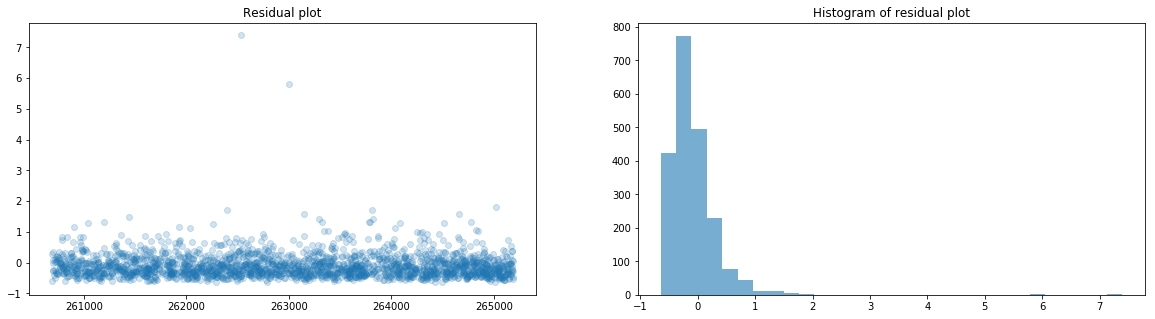

In [855]:
model = Lin_Reg()
model.fit(x_train, y_train)

print('Coeff is:', model.coef_ )
# print('Intercept is:', model.intercept_ )

score = model.score(x_test, y_test)
print('R^2 is:', score)

pred = model.predict(x_test)
diff = (np.exp(pred) - np.exp(y_test)) / np.exp(y_test)
f, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 5))
ax1.plot(diff, 'o', alpha = 0.2)
ax2.hist(diff, bins=30, alpha=0.6)
ax1.set_title('Residual plot')
ax2.set_title('Histogram of residual plot')
plt.show()

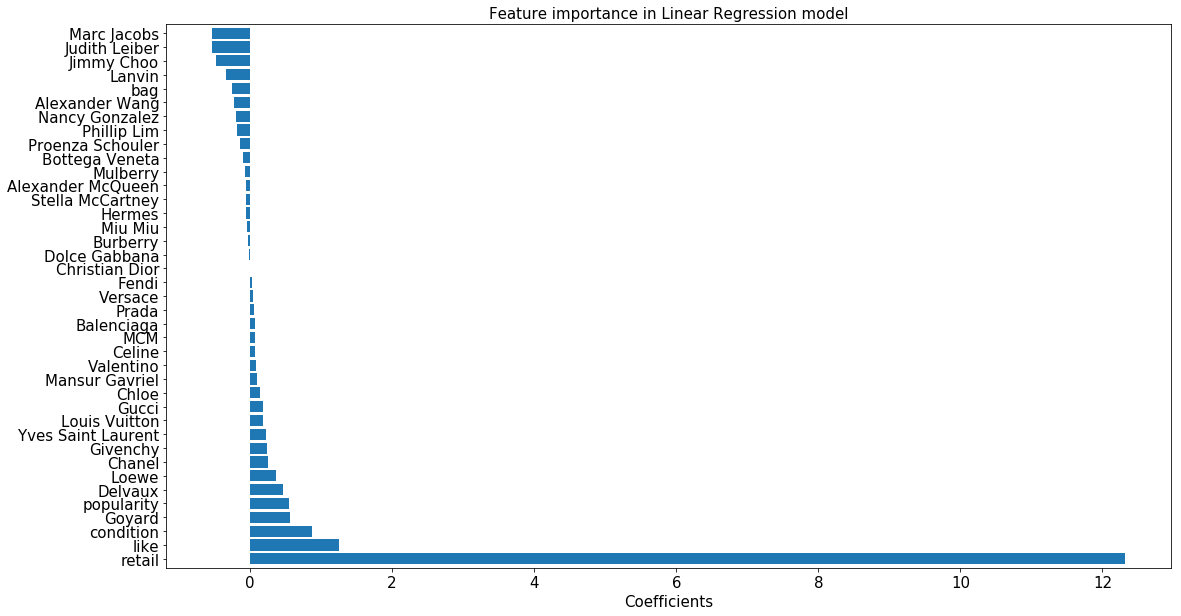

In [856]:
coef = pd.Series(model.coef_, index = x_train.columns)
newcoef = pd.DataFrame(coef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=[False])

matplotlib.rcParams['figure.figsize'] = (18.0, 10.0)
newcoef_sorted.plot(kind = "barh", width = 0.8, legend=None, fontsize = 15)
plt.xlabel('Coefficients',fontsize = 15)
plt.title('Feature importance in Linear Regression model', fontsize = 15)
plt.show()

### Ridge Regression

In [857]:
num_lambdas = 100
lambdas= np.linspace(-2, 2, num_lambdas)

cv_ridge = [cross_val_score(Ridge(alpha = 10**i), x_train, y_train, scoring = 'r2' , cv = 5).mean() 
            for i in lambdas]

Ridge Regression:  R^2 on training set 0.6803


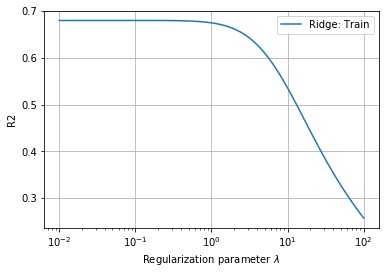

In [858]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogx(10.0**lambdas, (cv_ridge), label='Ridge: Train')

ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel('R2')

ax.grid()
ax.legend(loc = 'best')

print ('Ridge Regression:  R^2 on training set', round(max(cv_ridge),4))

In [859]:
max_value = max(cv_ridge)
max_index = cv_ridge.index(max_value)
print("Lambda for max R2:", round(lambdas[max_index],4))

Lambda for max R2: -0.9899


In [860]:
best_ridge = Ridge(alpha = 10**(lambdas[max_index])).fit(x_train, y_train)

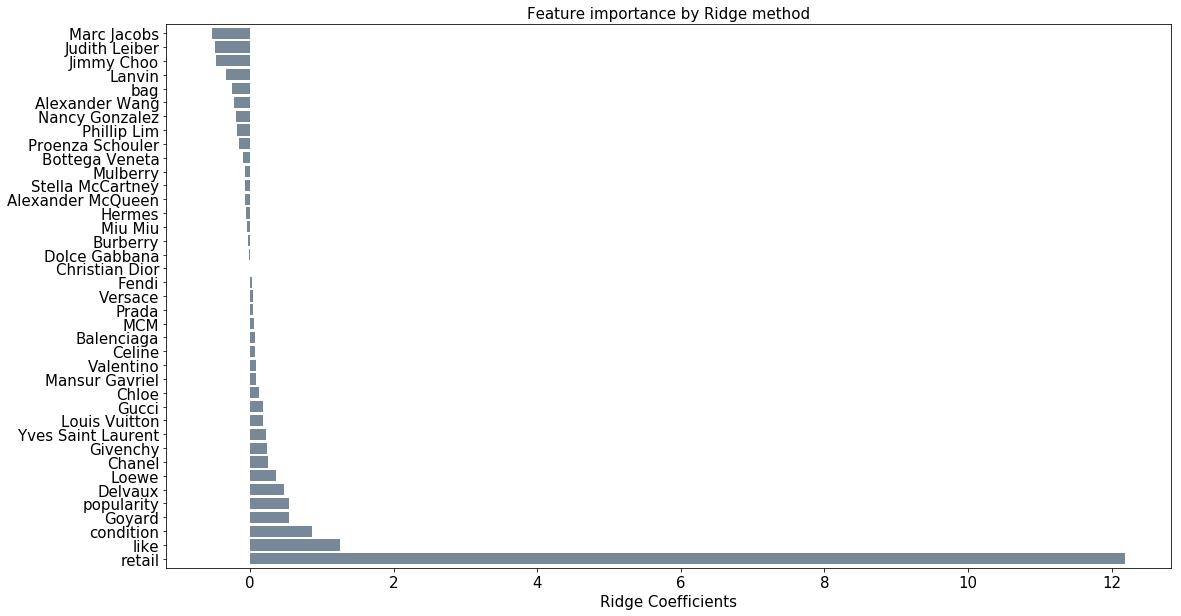

In [861]:
coef = pd.Series(best_ridge.coef_, index = x_train.columns)
newcoef = pd.DataFrame(coef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=[False])

matplotlib.rcParams['figure.figsize'] = (18.0, 10.0)
newcoef_sorted.plot(kind = "barh", width = 0.8, color = 'lightslategray', legend=None, fontsize = 15)
plt.xlabel('Ridge Coefficients',fontsize = 15)
plt.title('Feature importance by Ridge method', fontsize = 15)
plt.show()

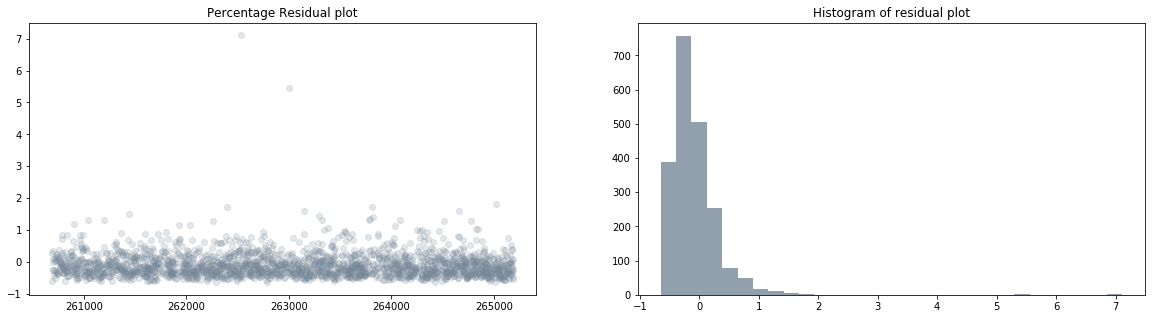

In [862]:
# Predict with our constructed Ridge model
pred = best_ridge.predict(x_test)
diff = (np.exp(pred) - np.exp(y_test)) / np.exp(y_test)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 5))
ax1.plot(diff, 'o', color = 'lightslategray', alpha = 0.2)
ax2.hist(diff, bins=30, color = 'lightslategray', alpha = 0.8)
ax1.set_title('Percentage Residual plot')
ax2.set_title('Histogram of residual plot')
plt.show()

# Louis Vuitton 
### Building a price prediction model for Louis Vuitton items

In [872]:
df_lv = df_price_retail[df_price_retail['brand']=='Louis Vuitton']

In [873]:
df_lv.shape

(2225, 14)

In [874]:
df_lv['name'].describe()

count                                 2225
unique                                1278
top       LOUIS VUITTON Monogram Speedy 30
freq                                    20
Name: name, dtype: object

In [875]:
# Popular Louis Vuitton items
lv_popular = df_lv['name'].value_counts()
lv_popular.head(20)

LOUIS VUITTON Monogram Speedy 30                    20
LOUIS VUITTON Damier Ebene Neo Neverfull MM         19
LOUIS VUITTON Monogram Artsy MM                     17
LOUIS VUITTON Damier Azur Speedy 30                 16
LOUIS VUITTON Monogram Odeon PM                     15
LOUIS VUITTON Monogram Speedy 25                    14
LOUIS VUITTON Damier Ebene Speedy 30                14
LOUIS VUITTON Monogram Tivoli GM                    13
LOUIS VUITTON Monogram Delightful PM                12
LOUIS VUITTON Monogram Keepall Bandouliere 55       11
LOUIS VUITTON Monogram Speedy Bandouliere 30        11
LOUIS VUITTON Damier Ebene Speedy Bandouliere 30    10
LOUIS VUITTON Monogram Noe                          10
LOUIS VUITTON Damier Azur Neo Neverfull MM          10
LOUIS VUITTON Damier Ebene Cosmetic Pouch           10
LOUIS VUITTON Monogram Zippy Wallet                 10
LOUIS VUITTON Damier Ebene Geronimos                10
LOUIS VUITTON Monogram Keepall 55                    9
LOUIS VUIT

In [876]:
# select relevant columns, convert to dummy variables
df_lv_dummy = pd.concat([df_lv.retail.str.replace(',', '').astype(float),
                                   df_lv.bag.fillna(0),
                                   df_lv.like.fillna(0),
                                   df_lv.popularity.fillna(0),
                                   df_lv['condition'],
                                   df_lv.price], axis = 1)
df_lv_dummy.shape

(2225, 6)

In [877]:
# training and testing datasets
x = df_lv_dummy.drop(['price'], axis = 1)
y = df_lv_dummy['price']

# standardize
x_temp = x.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_temp)
x = pd.DataFrame(x_scaled, columns=x.columns)

x_train = x[:1750]
y_train = y[:1750]

x_test = x[1750:]
y_test = y[1750:]

Coeff is: [4168.37795092 -190.14228711  745.25514745  282.67710258  856.27260233]
Intercept is: -329.13885035513704
R^2 is: 0.7063959876463081


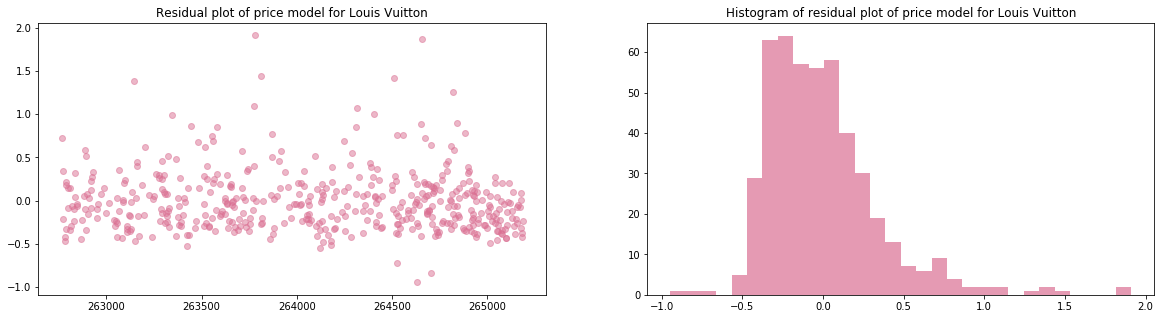

In [878]:
model = Lin_Reg()
model.fit(x_train, y_train)

print('Coeff is:', model.coef_ )
print('Intercept is:', model.intercept_ )

score = model.score(x_test, y_test)
print('R^2 is:', score)

pred = model.predict(x_test)
diff = (pred - y_test) / y_test
f, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 5))
ax1.plot(diff, 'o', color = 'palevioletred', alpha = 0.5)
ax2.hist(diff, bins=30, color = 'palevioletred', alpha = 0.7)
ax1.set_title('Residual plot of price model for Louis Vuitton')
ax2.set_title('Histogram of residual plot of price model for Louis Vuitton')
plt.show()

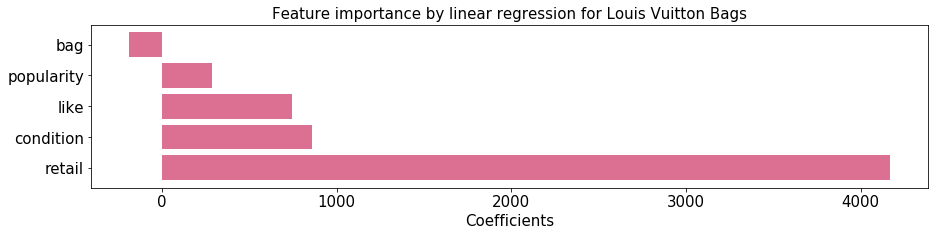

In [879]:
coef = pd.Series(model.coef_, index = x_train.columns)
newcoef = pd.DataFrame(coef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=[False])

matplotlib.rcParams['figure.figsize'] = (15, 3)
newcoef_sorted.plot(kind = "barh", width = 0.8, color = 'palevioletred', legend=None, fontsize = 15)
plt.xlabel('Coefficients',fontsize = 15)
plt.title('Feature importance by linear regression for Louis Vuitton Bags', fontsize = 15)
plt.show()

## Predict revenue on sold items 

In [628]:
df_recent_sold = df[df['sold']==True & (df['sold_date']!='2018-11-22') 
                    & (df['sold_date']!='2018-11-21') & (df['price'].notnull()) 
                   & (df['retail'].notnull())]

In [629]:
df_recent_sold.shape

(4566, 14)

In [630]:
df_recent_sold_dummy = pd.concat([df_recent_sold.retail.str.replace(',', '').astype(float),
                                   df_recent_sold.bag.fillna(0),
                                   df_recent_sold.like.fillna(0),
                                   pd.get_dummies(df_recent_sold['condition'], prefix = 'con_'),
                                   pd.get_dummies(df_recent_sold['brand']),
                                   df_recent_sold.price], axis = 1)